In [1]:
#Lab | Imbalanced data

#We will be using the files_for_lab/customer_churn.csv dataset to build a churn predictor.

#Instructions
# 1. Load the dataset and explore the variables.
# 2. We will try to predict variable Churn using a logistic regression on variables tenure, 
    #SeniorCitizen,MonthlyCharges.
# 3. Extract the target variable.
# 4. Extract the independent variables and scale them.
# 5. Build the logistic regression model.
# 6. Evaluate the model.
# 7. Even a simple model will give us more than 70% accuracy. Why?
# 8. Synthetic Minority Oversampling TEchnique (SMOTE) is an over sampling technique based on nearest neighbors
    #that adds new points between existing points. Apply imblearn.over_sampling.SMOTE to the dataset. 
    #Build and evaluate the logistic regression model. Is there any improvement?

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import math
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
pd.set_option('display.max_columns', None) 
#pd.set_option('display.max_rows', None)

In [4]:
customer_data=pd.read_csv('customer_churn.csv')
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data preparation

In [5]:
customer_data.isna().sum() #no NaNs
customer_data.shape
customer_data['tenure'].value_counts(dropna=False)
customer_data['MonthlyCharges'].value_counts(dropna=False)

20.05     61
19.85     45
19.95     44
19.90     44
20.00     43
          ..
23.65      1
114.70     1
43.65      1
87.80      1
78.70      1
Name: MonthlyCharges, Length: 1585, dtype: int64

In [6]:
customer_data['SeniorCitizen'].value_counts(dropna=False)

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [7]:
customer_data.dtypes #most dtypes are looking consistent with their titles. Except for SeniorCitizen
#As we can see above, SeniorCitizen is either 0 or 1 (category).

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [8]:
customer_data['SeniorCitizen'] = customer_data['SeniorCitizen'].astype('object') # This will be treated as categorical
customer_data.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [9]:
#Extracting the columns to be used in this model

customer_data.drop(['customerID', 'gender',  'Partner', 'Dependents',
        'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'TotalCharges'], axis=1, inplace=True)


# X-y split

In [10]:
X = customer_data.drop('Churn',axis = 1)
y = customer_data['Churn']

customer_data.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn'], dtype='object')

# Checking for multicollinearity

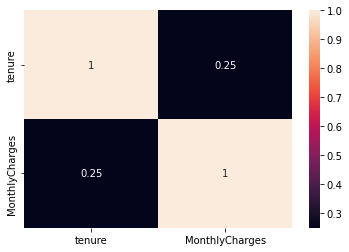

In [11]:
correlations_matrix = X.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

# Checking for distributions

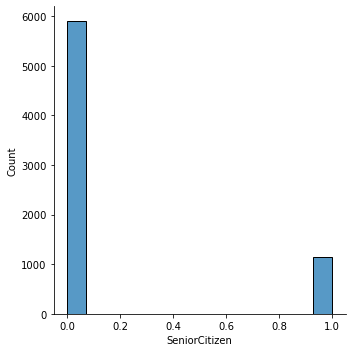

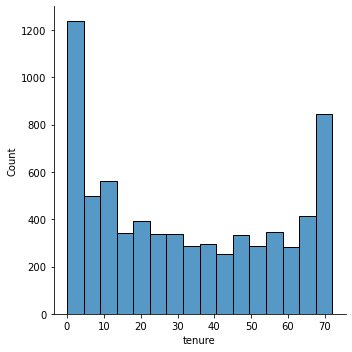

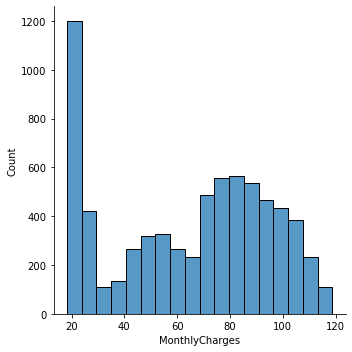

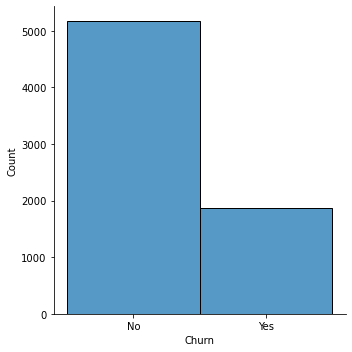

In [12]:
sns.displot(customer_data['SeniorCitizen'])
plt.show()

sns.displot(customer_data['tenure'])
plt.show()

sns.displot(customer_data['MonthlyCharges'])
plt.show()

sns.displot(customer_data['Churn'])
plt.show()

In [13]:
#Looking at the bar plot of churn, we can see that there is significant imbalance

customer_data['Churn'].value_counts(dropna=False)

No     5174
Yes    1869
Name: Churn, dtype: int64

# Train-test split

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # default fraction is .2

# MinMaxScaling & Encoding

In [15]:
#MinMaxScaling

from sklearn.preprocessing import MinMaxScaler

# X_train
X_train_num = X_train.select_dtypes(include = np.number)
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = pd.DataFrame(transformer.transform(X_train_num), columns=X_train_num.columns)

# X_test (using the transformer that we created above in the training stage)
X_test_num = X_test.select_dtypes(include = np.number)
X_test_normalized = pd.DataFrame(transformer.transform(X_test_num), columns=X_test_num.columns)


#OneHotEncoding

from sklearn.preprocessing import OneHotEncoder

# X_train
X_train_cat = X_train.select_dtypes(include = object)
encoder = OneHotEncoder(drop='first').fit(X_train_cat) # need to keep encoder
cols=encoder.get_feature_names_out(input_features=X_train_cat.columns)
encoded = encoder.transform(X_train_cat).toarray() #we want to transform the X_cut and make it an array
X_train_encoded = pd.DataFrame(encoded,columns=cols) #make it a df

# X_test (using the encoder that we created above in the training stage)
X_test_cat = X_test.select_dtypes(include = object)
cols=encoder.get_feature_names_out(input_features=X_test_cat.columns)
encoded = encoder.transform(X_test_cat).toarray()
X_test_encoded = pd.DataFrame(encoded,columns=cols) 


In [16]:
# Building X_t_transformed dfs back by concatenating the transformed and the concatenating

X_train_transformed = np.concatenate([X_train_normalized, X_train_encoded], axis=1)

X_test_transformed = np.concatenate([X_test_normalized, X_test_encoded], axis=1)

In [17]:
y_train = y_train.reset_index(drop=True) 
# needed because the transformation also reset the index for X_train_scaled
# so we need this for y_test as well...
y_test = y_test.reset_index(drop=True) 


In [18]:
y_train.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: object

# Model Building

In [19]:
customer_data['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [20]:
5174/(5174+1869) #the accuracy of predicting Churn as 'No' at all cases.

0.7346301292063041

In [21]:
#Logistic Regression Model

In [22]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='lbfgs')
LR.fit(X_train_transformed, y_train)
LR.score(X_test_transformed, y_test) #this is the accuracy score. 78 percent of the cases, the model made the right choice.

# Always compare your model with the stupidest model of giving only the 'one side' for all the cases. 

0.7825099375354913

# Metrics

In [23]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score #the harmonized mean of the precision and recall. a trade off between the two

pred = LR.predict(X_test_transformed)

print("precision: ",precision_score(y_test,pred,pos_label='Yes')) #precision is 61%. Out of the cases that we said the person woul quit, 61 percent had.
print("recall: ",recall_score(y_test,pred,pos_label='Yes'))  #?? 45% was the perc that was correctly caught by the model.
print("f1: ",f1_score(y_test,pred,pos_label='Yes'))


precision:  0.6176470588235294
recall:  0.4535637149028078
f1:  0.5230386052303861


In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,pred) 

array([[1168,  130],
       [ 253,  210]])

In [25]:
# predicted  | No  | Yes |  
# ------------------------
# actual  No |1168 | 130| 
# ------------------------
#        Yes | 253| 210|
# ------------------------

In [27]:
y_test.value_counts()

No     1298
Yes     463
Name: Churn, dtype: int64

In [26]:
pd.Series(pred).value_counts()

No     1421
Yes     340
dtype: int64

# SMOTE

In [28]:
# Treating the imbalanced data for improved predictions

In [29]:
# 8. Synthetic Minority Oversampling TEchnique (SMOTE) is an over sampling technique based on nearest neighbors
    #that adds new points between existing points. Apply imblearn.over_sampling.SMOTE to the dataset. 
    #Build and evaluate the logistic regression model. Is there any improvement?

In [30]:
from imblearn.over_sampling import SMOTE #cretates synthetic samples using KNN

#The samples are very similar to the neighbours but not identical

In [31]:
sm = SMOTE(random_state=100, k_neighbors=3)
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train_transformed,y_train)

In [32]:
X_train_SMOTE.shape

(7752, 3)

In [33]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='lbfgs')
LR.fit(X_train_SMOTE, y_train_SMOTE)
pred = LR.predict(X_test_transformed)

print("precision: ",precision_score(y_test,pred,pos_label='Yes')) #precision is 47%. Out of the cases that we said the person would quit, 61 percent had.
print("recall: ",recall_score(y_test,pred,pos_label='Yes'))  #?? 72% was the perc that was correctly caught by the model.
print("f1: ",f1_score(y_test,pred,pos_label='Yes'))

precision:  0.47982708933717577
recall:  0.7192224622030238
f1:  0.5756266205704408


In [38]:
LR.score(X_test_transformed, y_test) #accuracy declined to 0.72

0.7211811470755253

In [36]:
y_test.value_counts()

No     1298
Yes     463
Name: Churn, dtype: int64

In [35]:
pd.Series(pred).value_counts()

No     1067
Yes     694
dtype: int64

In [34]:
confusion_matrix(y_test,pred)

array([[937, 361],
       [130, 333]])

In [37]:
# predicted   | No  | Yes |  
# ------------------------
# actual  No  |937 | 361| 
# ------------------------
#        Yes | 130| 333|
# ------------------------

# Comment

In [ ]:
# IT LOOKS TO ME THAT MODEL WORSENED. AM I DOING SOMETHING WRONG?